In [1]:
import pyslammer as slam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# Load the northridge ground motion
histories = slam.sample_ground_motions()
motion = histories["Northridge_PAC-175"]
scaled_pga = 0.4
Tm = 0.47 # seconds (period of the ground motion)
output = {}

# Set range of ky values
kys = np.asarray([0.05, 0.1, 0.2, 0.4])

# Set range of Ts/Tm values
TsTm_low = np.linspace(0.2, 2, 12)
TsTm_high = np.linspace(2.2, 4, 6)
TsTms = np.concatenate((TsTm_low, TsTm_high))

# Version 1 (constant slope height)
version_1 = False
default_height = 30 # meters
default_vs = 600 # meters per second
# H = 30 # meters
# Vs = 4*H/(TsTms*Tm) # meters per second

# Version 2 (constant shear wave velocity)
# Vs = 600 # meters per second
# H = Vs * TsTms * Tm / 4 # meters

rigid_inputs = {"a_in": motion.accel, "dt": motion.dt, "target_pga": scaled_pga}
flexible_inputs = {
    "damp_ratio": -0.05,
    "ref_strain": 0.0005,
    "soil_model": "linear_elastic",
}
run = 0
for ky in kys:
    rigid_inputs["ky"] = float(ky)
    for TsTm in TsTms:
        if version_1:
            flexible_inputs["height"] = default_height
            Vs = 4 * default_height / (TsTm * Tm)
            flexible_inputs["vs_slope"] = Vs
            flexible_inputs["vs_base"] = Vs
        else:
            flexible_inputs["height"] = TsTm * Tm * default_vs / 4
            flexible_inputs["vs_slope"] = default_vs
            flexible_inputs["vs_base"] = default_vs
    
        rigid_result = slam.RigidAnalysis(**rigid_inputs)
        decoupled_result = slam.Decoupled(**rigid_inputs, **flexible_inputs)
        coupled_result = slam.Coupled(**rigid_inputs, **flexible_inputs)
        output[run] = {
            "ky": round(ky, 2),
            "Ts/Tm": round(TsTm, 2),
            "H": round(flexible_inputs["height"], 2),
            "Vs": round(flexible_inputs["vs_slope"], 2),
            "rigid_disp": rigid_result.max_sliding_disp,
            "decoupled_disp": decoupled_result.max_sliding_disp,
            "coupled_disp": coupled_result.max_sliding_disp,
            "damp (d_im, d_tot, c_im, c_tot)": [decoupled_result._damp_imp, decoupled_result._damp_tot, coupled_result._damp_imp, coupled_result._damp_tot],
        }
        run += 1



In [3]:
# convert the output to a pandas dataframe
df = pd.DataFrame.from_dict(output, orient="index")
df


,ky,Ts/Tm,H,Vs,rigid_disp,decoupled_disp,coupled_disp,"damp (d_im, d_tot, c_im, c_tot)"
0,0.05,0.20,14.10,600,1.297274e-01,0.128627,0.178934,"[0.2, 0.15000000000000002, 0.2, 0.150000000000..."
1,0.05,0.36,25.64,600,1.297274e-01,0.157678,0.197508,"[0.2, 0.15000000000000002, 0.2, 0.150000000000..."
2,0.05,0.53,37.17,600,1.297274e-01,0.205814,0.178769,"[0.2, 0.15000000000000002, 0.2, 0.150000000000..."
3,0.05,0.69,48.71,600,1.297274e-01,0.282179,0.168401,"[0.2, 0.15000000000000002, 0.2, 0.150000000000..."
4,0.05,0.85,60.25,600,1.297274e-01,0.402887,0.155396,"[0.2, 0.15000000000000002, 0.2, 0.150000000000..."
...,...,...,...,...,...,...,...,...
67,0.40,2.56,180.48,600,4.022819e-17,0.000000,0.000000,"[0.2, 0.15000000000000002, 0.2, 0.150000000000..."
68,0.40,2.92,205.86,600,4.022819e-17,0.000000,0.000000,"[0.2, 0.15000000000000002, 0.2, 0.150000000000..."
69,0.40,3.28,231.24,600,4.022819e-17,0.000000,0.000000,"[0.2, 0.15000000000000002, 0.2, 0.150000000000..."
70,0.40,3.64,256.62,600,4.022819e-17,0.000000,0.000000,"[0.2, 0.15000000000000002, 0.2, 0.150000000000..."


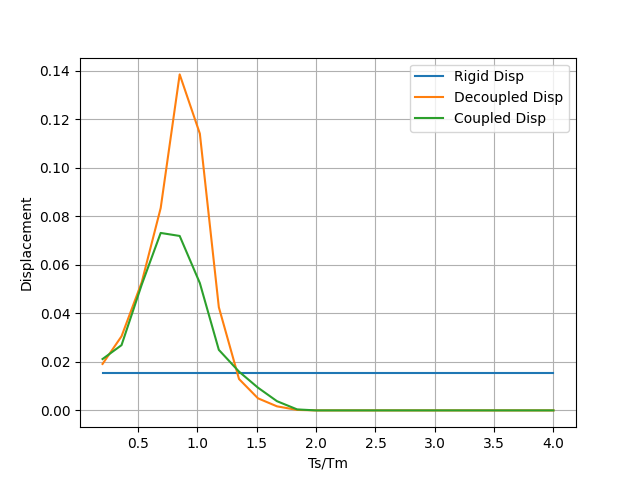

In [6]:
fig, ax = plt.subplots()
ky_01_data = df[df['ky'] == 0.2]
ax.plot(ky_01_data['Ts/Tm'], ky_01_data['rigid_disp'], label='Rigid Disp')
ax.plot(ky_01_data['Ts/Tm'], ky_01_data['decoupled_disp'], label='Decoupled Disp')
ax.plot(ky_01_data['Ts/Tm'], ky_01_data['coupled_disp'], label='Coupled Disp')
ax.set_xlabel('Ts/Tm')
ax.set_ylabel('Displacement')
ax.legend()
ax.grid(True)

In [ ]:
# plt.close("all")